# Deep Transfer Learning for Biomedical Image Data

In biomedical, the task of predicting a condition from image data is highly important to diagnose a variety of medical conditions. In computer science, this task is called image classification. Algorithmic image classification is usually performed using a specific type of algorithm called deep learning. Deep learning is a subset of machine learning, in which the algorithm is trained using data.

In image classification using deep learning, the workflow usually goes as follows:

1. Create a dataset with a folder for each class of image.
2. Split this dataset into training, validation, and testing sets.
3. Train the model using the training set.
4. Optimize the training parameters using the validation set.
5. Evaluate the model using the testing set.


Deep learning has been successfully used to accurately classify many types of biomedical images. Very recently, a classification algorithm was able to detect breast cancer from mammography images with an accuracy of 98% [[1]](https://www.nature.com/articles/s41598-019-48995-4). In collaboration with Dr Ilmi Yoon, Domingo Lab and her graduate students, the accuracy of the classification of images of tadpole (frog) embryos stained with muscle and intersomitic boundaries was improved using deep transfer learning. These images were classified into two categories: control and mutant. This notebook outlines the core algorithm used for this task in a general way, so that future experiments with novel datasets can easily be conducted.

## Background

Before any code is run, it is important to understand some basics of neural networks and transfer learning.

### Deep Neural Networks
A deep neural network is a conditional probability estimator which can predict the probability of some condition given some input. This makes it useful for image classification, which involves detecting the probability of a condition once provided with an image. This project an industry standard neural network architecture called VGG16 (see image), which accepts color images as input and predicts the probability that the image belongs to any of 1000 general image classes.

![VGG16 Architecture](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)


This network is composed of many network layers. Each layer further processes the image. The output layer is the orange block at the end of the network, which outputs the probability distribution among the image classes.

### Transfer Learning
While Deep Learning has advanced recognition of patterns and understanding of data in various formats, recent advancements in Convolution Neural Network (CNN) achieve super-human level computer vision in natural photo images [3]. Typical human error in image recognition is 5% while the latest CNN models such as VGG19, Inception achieves 3% or lower rates [4]. These achievements are made with advanced Convolution Neural Network (CNN) architecture design, careful selection of hyperparameters, the large and good data set (more than 15 million labeled images) and high computation power for long deep learning training; typical computer science lab will have difficulty in achieving the same results. Fortunately, to promote the advancement of deep learning applications, Google, Oxford research group or other most advanced researchers made their fully trained CNN publicly available through “Transfer Learning” technology [4]. However, these fully trained CNN are trained with objects naturally found from photo images such as dog, cat, car, etc. Scientists or domain experts have started to utilize these fully-trained-CNN to classify their scientific data with small additional training process (called fine-tuning).
Transfer learning is the process fine-tuning a well trained neural network (like VGG16) for a specific task. This has been proven to be effective at classifying medical image data with minimal training time and smaller datasets than would otherwise be required for high levels of accuracy. The output layer with 1000 classes is replaced with a custom layer with the number of outputs equal to the number of classes of image we have. In this project, the classes are control and mutant. The network is then retrained with a small hand-labeled dataset.

## Introduction to Colab Notebooks

### Running a Code Cell

The cell below is written in python code. In order to execute a cell, press the play button next to the cell, or press Shift-Enter while within a code cell. The output generated by a cell will be shown below the cell. Try executing the cell below.

In [1]:
print('Hello World')

Hello World


The output should read 'Hello World'.


### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project.

In [2]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision for datasets, models, and transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Standard libraries
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Import Success!")

Using device: cuda:0
Import Success!


## Working with Training Data

The data must be loaded into the Keras API (a software library) so that it can be easily fed to the machine learning model.


### Extract the Data from directory

Since the images are in a .zip file, they must first be extracted to .jpg images.

In [3]:
import zipfile
from pathlib import Path

# --- 1. Define Paths ---
# Assumes 'cropdata.zip' is in the same directory as the notebook.
zip_path = Path('./datasets/cropdata.zip')
extract_path = Path('./datasets/')

# --- 2. Extract the Data ---
# Create the extraction directory if it doesn't already exist
extract_path.mkdir(exist_ok=True) 

# Unzip the file
print(f"Extracting {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction Done.")

Extracting datasets/cropdata.zip...
Extraction Done.


### Splitting the Dataset

The data is divided in to three sets: train, validation, and test. The training data will be used to train the model. The validation data will be run through the model occationally to ensure that it is generalizing well to input outside the training cases (not overfitting). The validation data is used to determine the optimal amount of training. The test data will be kept until training is completely done in order to measure our peformance.

In [4]:
train_path = extract_path / 'cropdata/train'
valid_path = extract_path / 'cropdata/valid'
test_path = extract_path / 'cropdata/test'

print("Paths Loaded:")
print(f"Train path: {train_path}")
print(f"Validation path: {valid_path}")
print(f"Test path: {test_path}")

Paths Loaded:
Train path: datasets/cropdata/train
Validation path: datasets/cropdata/valid
Test path: datasets/cropdata/test


### Creating the Data Loaders

The model requires the image to be provided as batches of tensors. In PyTorch, this is handled by defining transformations (like resizing and normalization) and then using `ImageFolder` to load the data from directories, which is then wrapped by a `DataLoader` to create batches.

In [5]:
# Define the transformations for the images.
# VGG16 expects 224x224 images. We also normalize with the standard ImageNet stats.
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_path, transform=image_transforms)
valid_dataset = datasets.ImageFolder(valid_path, transform=image_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=image_transforms)

# Create data loaders to handle batching
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ['control', 'mutant']

print("Data loaders created.")
print(f"Training data: {len(train_dataset)} images")
print(f"Validation data: {len(valid_dataset)} images")
print(f"Testing data: {len(test_dataset)} images")

Data loaders created.
Training data: 454 images
Validation data: 113 images
Testing data: 189 images


### Visualizing the Data

The following code will display some of the training images so we can see what they look like. Note that we need to un-normalize the images to display them correctly.

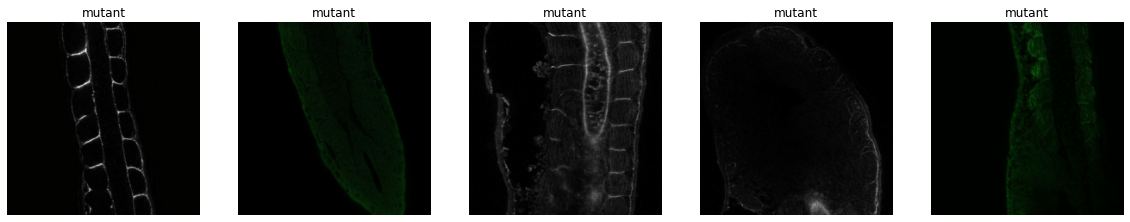

In [6]:
def imshow(inp, title=None):
    """Helper function to un-normalize and display an image"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get one batch of training images
inputs, class_indices = next(iter(train_loader))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs[0:5])
class_names = train_dataset.classes
titles = [class_names[x] for x in class_indices[0:5]]

# Plot the images
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    img = inputs[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(titles[i])

## Creating the Model

In Keras, the deep learning model is represented by layers of processing.
After importing a pretrained model, a new model is created using this model. All of these layers are copied from the pretrained model to the new model. However, the final output layer will be replaced and retrained using the labeled data, esssentially customizing the output for this specific classification task.

### Loading a Pretrained Model

A pretrained VGG16 model is downloaded using the `torchvision.models` library.

In [7]:
vgg16_model = models.vgg16(pretrained=True)

/home/patel.pranav2/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/patel.pranav2/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Creating a Custom Output Model

We will now adapt the pretrained model for our task. First, we freeze all the parameters in the feature extraction part of the network (`model.features`) so they are not updated during training. Then, we replace the final classifier layer with a new linear layer that has two outputs, corresponding to our 'control' and 'mutant' classes. Note that the `CrossEntropyLoss` function in PyTorch implicitly applies a softmax function, so we do not need to add a separate softmax layer.

In [9]:
# Freeze the parameters of the convolutional base
for param in vgg16_model.features.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier's last layer
n_inputs = vgg16_model.classifier[6].in_features

# Replace the last layer with a new one for our specific number of classes
vgg16_model.classifier[6] = nn.Linear(n_inputs, len(classes))

# Move the model to the specified device (GPU or CPU)
model = vgg16_model.to(device)

# Print the modified classifier part of the model
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


## Training the Model

Now that the model has been specified, it must be trained to detect mutated frog images.

### Defining Loss Function and Optimizer
In preparation for training, we define the loss function and the optimizer. We will use Cross-Entropy Loss, which is standard for multi-class classification tasks. For the optimizer, we'll use Adam. Crucially, we only pass the parameters of the *new, trainable* final layer to the optimizer, ensuring that the frozen layers are not updated.

In [10]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, only passing the parameters of the final trainable layer
# The learning rate of 0.01 is quite high for Adam, but we will keep it for consistency.
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.01)

print("Done")

Done


### Minimizing Loss

The model is now trained using backpropagation. In PyTorch, we write an explicit training loop. For each epoch (a full pass through the dataset), we iterate through the training data, calculate the model's predictions, compute the loss, and update the model's weights. We also evaluate the model on the validation set at the end of each epoch to monitor for overfitting and track performance on unseen data.

In [12]:
num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc.item())

    # --- Validation Phase ---
    model.eval()  # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
            
    val_epoch_loss = val_running_loss / len(valid_dataset)
    val_epoch_acc = val_running_corrects.double() / len(valid_dataset)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} - '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

print("Training Complete!")

Epoch 1/50 - Train Loss: 0.9114 Acc: 0.8062 - Val Loss: 0.3525 Acc: 0.9027
Epoch 2/50 - Train Loss: 0.3812 Acc: 0.9009 - Val Loss: 0.1247 Acc: 0.9646
Epoch 3/50 - Train Loss: 0.3204 Acc: 0.9251 - Val Loss: 0.1238 Acc: 0.9469
Epoch 4/50 - Train Loss: 0.3363 Acc: 0.9361 - Val Loss: 0.0786 Acc: 0.9912
Epoch 5/50 - Train Loss: 0.1723 Acc: 0.9471 - Val Loss: 0.0422 Acc: 0.9735
Epoch 6/50 - Train Loss: 0.1338 Acc: 0.9604 - Val Loss: 0.1279 Acc: 0.9735
Epoch 7/50 - Train Loss: 0.6734 Acc: 0.9031 - Val Loss: 0.1974 Acc: 0.9735
Epoch 8/50 - Train Loss: 0.2553 Acc: 0.9537 - Val Loss: 0.2327 Acc: 0.9381
Epoch 9/50 - Train Loss: 0.2274 Acc: 0.9559 - Val Loss: 0.1190 Acc: 0.9735
Epoch 10/50 - Train Loss: 0.1942 Acc: 0.9648 - Val Loss: 0.1617 Acc: 0.9823
Epoch 11/50 - Train Loss: 0.1568 Acc: 0.9648 - Val Loss: 0.1304 Acc: 0.9558
Epoch 12/50 - Train Loss: 0.1834 Acc: 0.9670 - Val Loss: 0.1690 Acc: 0.9735
Epoch 13/50 - Train Loss: 0.2196 Acc: 0.9559 - Val Loss: 0.3911 Acc: 0.9381
Epoch 14/50 - Train L

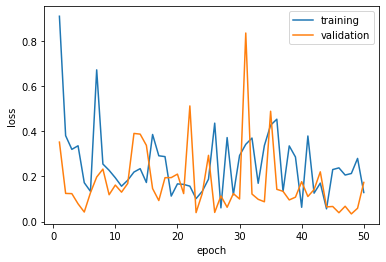

In [13]:
# Plot loss history
epoch_nums = range(1, num_epochs + 1)
training_loss = history["train_loss"]
validation_loss = history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Testing the Model

To perform a final test of the model, the test data is passed through it. It is important to use data that was held out from the training and validation processes to get an unbiased estimate of performance. The accuracy is calculated and a confusion matrix is generated.

### Test Accuracy

To calculate accuracy, we put the model in evaluation mode (`model.eval()`) and iterate through the test data loader, accumulating the number of correct predictions.

In [14]:
# Set model to evaluation mode
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9841


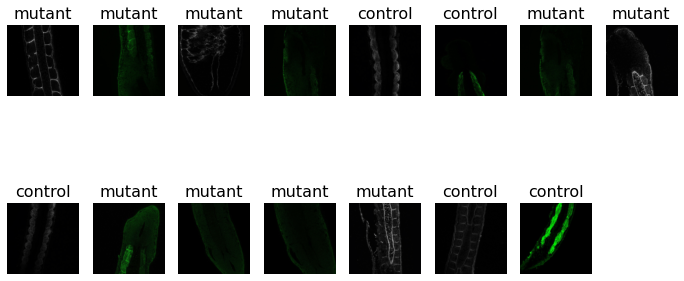

In [15]:
# Helper function to un-normalize and plot images
def plots_pytorch(images, labels, class_names, rows=2):
    """Un-normalizes and plots a batch of images with their labels."""
    fig = plt.figure(figsize=(12, 6))
    cols = len(images) // rows if len(images) % rows == 0 else len(images) // rows + 1
    
    # Define the mean and std used for normalization to reverse it
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(len(images)):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('Off')
        
        # PyTorch tensors are (C, H, W), matplotlib needs (H, W, C)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        
        # Un-normalize the image
        img = std * img + mean
        img = np.clip(img, 0, 1) # Clip values to be between 0 and 1
        
        # Get the title from the class index
        title = class_names[labels[i]]
        ax.set_title(title, fontsize=16)
        
        plt.imshow(img)

# Get a batch of images from the training data loader
images, labels = next(iter(train_loader))

# Plot the images
plots_pytorch(images, labels, class_names=train_dataset.classes, rows=2)

### Confusion Matrix

A confusion matrix gives more insight than just accuracy: It indicates which images were classified correctly, and for the incorrect ones, it indicates how (mutant instead of control vs. control instead of mutant). It allows us to determine which classes the model performed well on and which classes the model performed poorly on. If a model performs poorly on a specific class, it may be cauesed by an unclean dataset or insufficient quanitity of images of that class.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Confusion matrix, without normalization
[[ 86   1]
 [  2 100]]


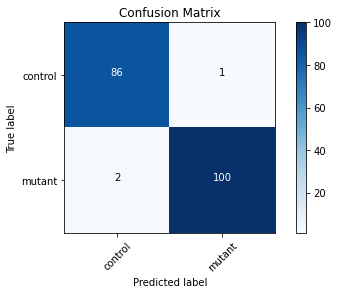

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get all predictions for the test set
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels.data.float()), dim=0)

# Convert tensors to numpy arrays for sklearn
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()
print(all_preds_np)

# Compute confusion matrix
cm = confusion_matrix(all_labels_np, all_preds_np)
cm_plot_labels = ['control', 'mutant']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining. In PyTorch, we save the model's learned parameters (the "state dictionary").

In [17]:
torch.save(model.state_dict(), 'fineTunedVGG16.pth')
print("Model Saved.")

Model Saved.


## Loading the fine-tuned VGG16 model

To use the saved model later, you first need to instantiate the model architecture and then load the saved state dictionary into it.

In [18]:
# Re-create the model architecture
loaded_model = models.vgg16() 
n_inputs = loaded_model.classifier[6].in_features
loaded_model.classifier[6] = nn.Linear(n_inputs, len(classes))

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load('fineTunedVGG16.pth'))
loaded_model.to(device) # Move to GPU if available
loaded_model.eval() # Set to evaluation mode

print("Model Loaded.")

<ipython-input-18-75c03712f3ae>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('fineTunedVGG16.pth'))


Model Loaded.


## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is downloaded, transformed, and loaded using `torchvision` utilities. Then, the model is defined by loading a pretrained model and adding a new output layer. Once defined, the model is trained with an explicit training loop, minimizing the loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict more than two classes and scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets.